Can we even use the joint distribution to learn the posterior?

$$ p(\theta \mid x) = \int p(x \mid z, \theta) p(z \mid \theta) p(\theta) dz $$

Learn the posterior by forward sampling $\theta → z → x$

### Toy Example

$$ p(x \mid \theta) = N(\theta, 1) $$

$$ p(\theta) = N(5, 1) $$

In [1]:
from scipy.stats import norm

theta = norm.rvs(loc = 5, scale = 1, size = 100)

X = norm.rvs(loc = theta, scale = 1, size = 100)

## Normalizing Flows

In [62]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os

%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

In [10]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
exp_transform = T.ExpTransform()

In [11]:
dist_y = dist.TransformedDistribution(dist_x, [exp_transform])

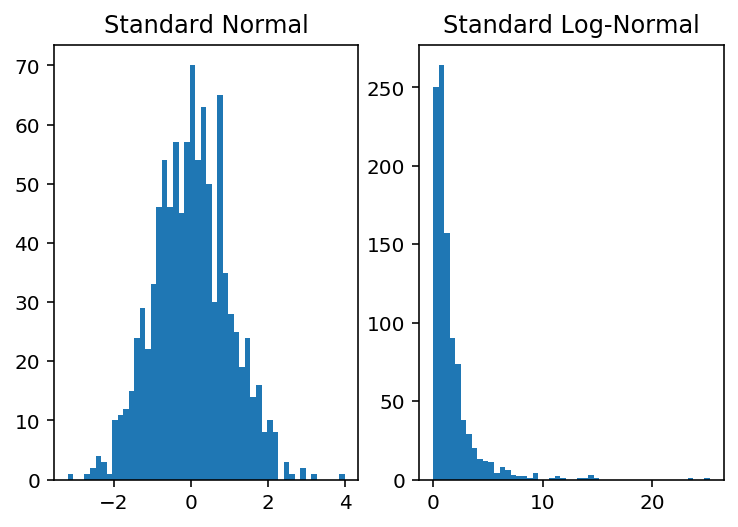

In [12]:
plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Standard Log-Normal')
plt.show();

Our example uses a single transform. However, we can compose transforms to produce more expressive distributions. For instance, if we apply an affine transformation we can produce the general log-normal distribution,

$$ X \sim N(0, 1) $$

$$ Y = exp(\mu + \sigma X) $$

or rather, $𝑌 \sim \text{LogNormal}(\mu, \sigma^2)$. In Pyro this is accomplished, e.g. for $\mu=3$, $\sigma=0.5$, as follows:

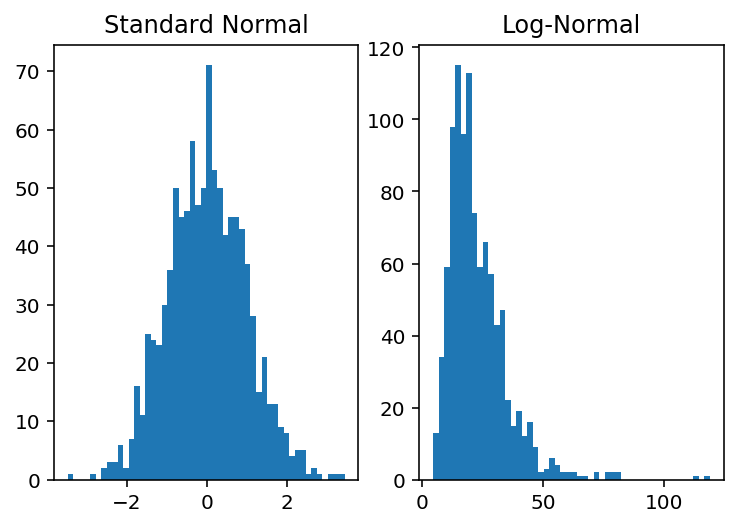

In [13]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
affine_transform = T.AffineTransform(loc=3, scale=0.5)

exp_transform = T.ExpTransform()
dist_y = dist.TransformedDistribution(dist_x, [affine_transform, exp_transform])

plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show();

### Learnable Univariate Distributions in Pyro

Having introduced the interface for invertible transforms and transformed distributions, we now show how to represent learnable transforms and use them for density estimation. Our dataset in this section and the next will comprise samples along two concentric circles. Examining the joint and marginal distributions:

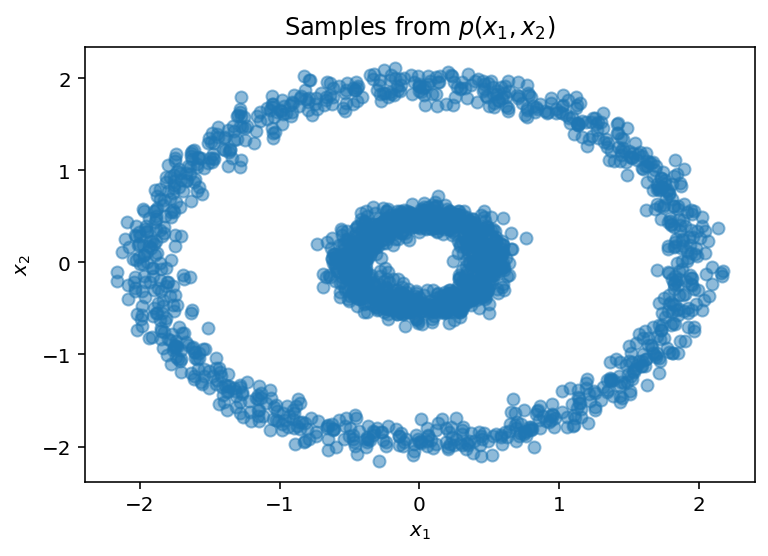

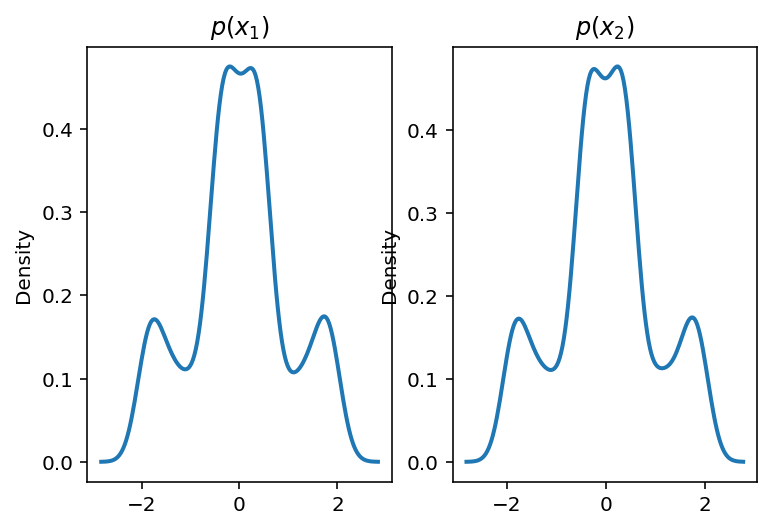

In [63]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 2000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.25, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show();

Standard transforms derive from the Transform class and are not designed to contain learnable parameters. Learnable transforms, on the other hand, derive from TransformModule, which is a `torch.nn.Module` and registers parameters with the object.

We will learn the marginals of the above distribution using such a transform, Spline [5,6], defined on a two-dimensional input:

In [55]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.Spline(2, count_bins=32)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

This transform passes each dimension of its input through a separate monotonically increasing function known as a spline. From a high-level, a spline is a complex parametrizable curve for which we can define specific points known as knots that it passes through and the derivatives at the knots. The knots and their derivatives are parameters that can be learnt, e.g., through stochastic gradient descent on a maximum likelihood objective, as we now demonstrate:

In [56]:
%%time

steps = 5000
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)

for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.673676013946533
step: 500, loss: 1.2019920349121094
step: 1000, loss: 1.197292685508728
step: 1500, loss: 1.1965861320495605
step: 2000, loss: 1.195388674736023
step: 2500, loss: 1.1952441930770874
step: 3000, loss: 1.193518877029419
step: 3500, loss: 1.1938239336013794
step: 4000, loss: 1.1967319250106812
step: 4500, loss: 1.192971110343933
CPU times: user 27.9 s, sys: 2.4 s, total: 30.3 s
Wall time: 27.4 s


Note that we call `flow_dist.clear_cache()` after each optimization step to clear the transform’s forward-inverse cache. This is required because flow_dist’s spline_transform is a stateful `TransformModule` rather than a purely stateless Transform object. Purely functional Pyro code typically creates Transform objects each model execution, then discards them after `.backward()`, effectively clearing the transform caches. By contrast in this tutorial we create stateful module objects and need to manually clear their cache after update.

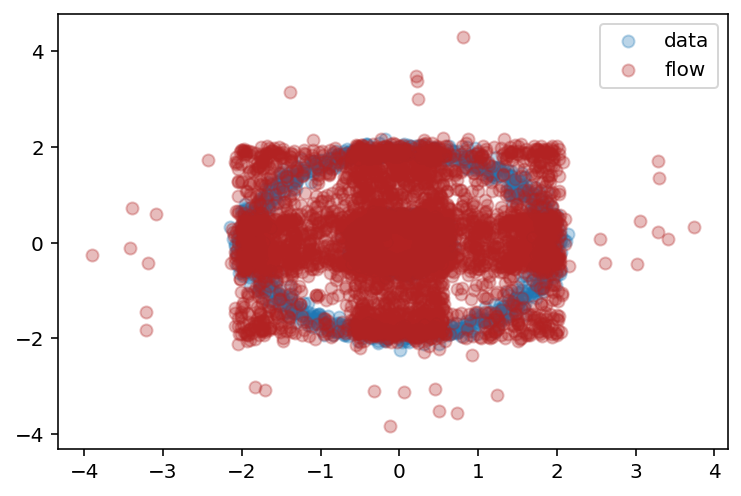

In [57]:
X_flow = flow_dist.sample(torch.Size([5000,])).detach().numpy()

plt.scatter(X[:,0], X[:,1], label='data', alpha=0.3)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.3)
plt.legend()
plt.show();

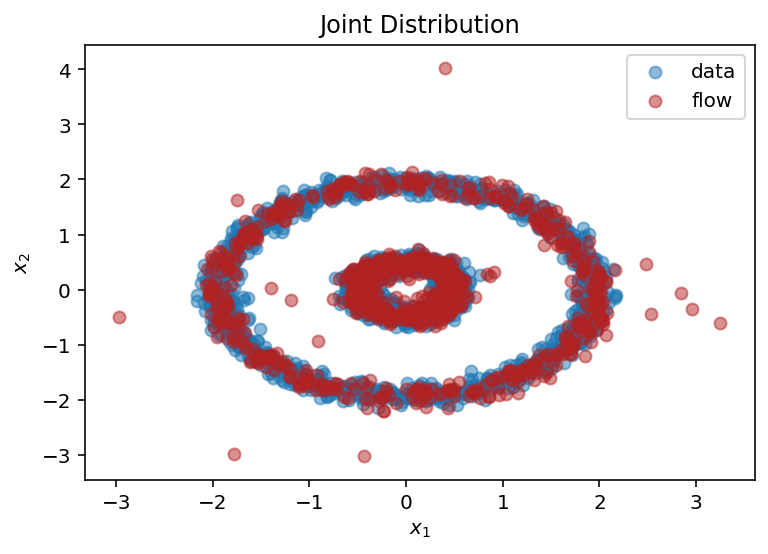

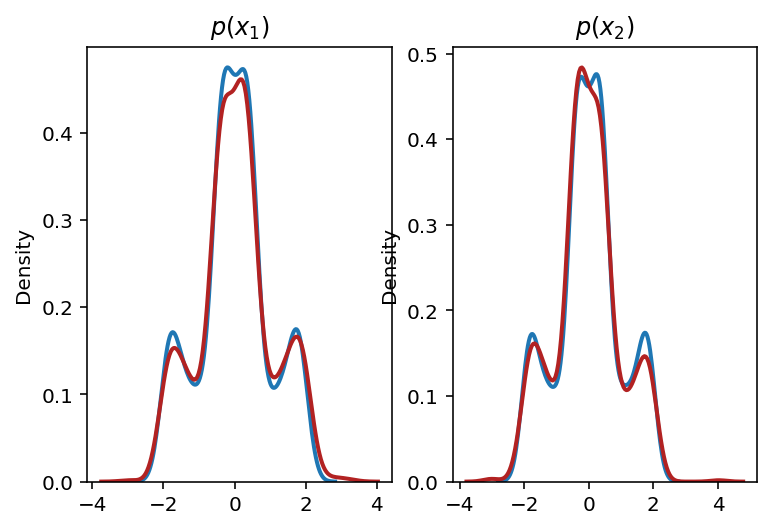

In [64]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show();

As we can see, we have learnt close approximations to the marginal distributions, 𝑝(𝑥1),𝑝(𝑥2). It would have been challenging to fit the irregularly shaped marginals with standard methods, e.g., a mixture of normal distributions. As expected, since there is a dependency between the two dimensions, we do not learn a good representation of the joint, 𝑝(𝑥1,𝑥2). In the next section, we explain how to learn multivariate distributions whose dimensions are not independent.

## Multivariate Distributions

In [58]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [59]:
%%time

steps = 5000
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 4.285391807556152
step: 500, loss: 1.6041830778121948
step: 1000, loss: 1.5903651714324951
step: 1500, loss: 1.57062566280365
step: 2000, loss: 1.5399857759475708
step: 2500, loss: 1.6155178546905518
step: 3000, loss: 1.5424128770828247
step: 3500, loss: 1.5398112535476685
step: 4000, loss: 1.5316929817199707
step: 4500, loss: 1.5226444005966187
step: 5000, loss: 1.5234458446502686
CPU times: user 1min 9s, sys: 8.18 s, total: 1min 17s
Wall time: 1min 13s


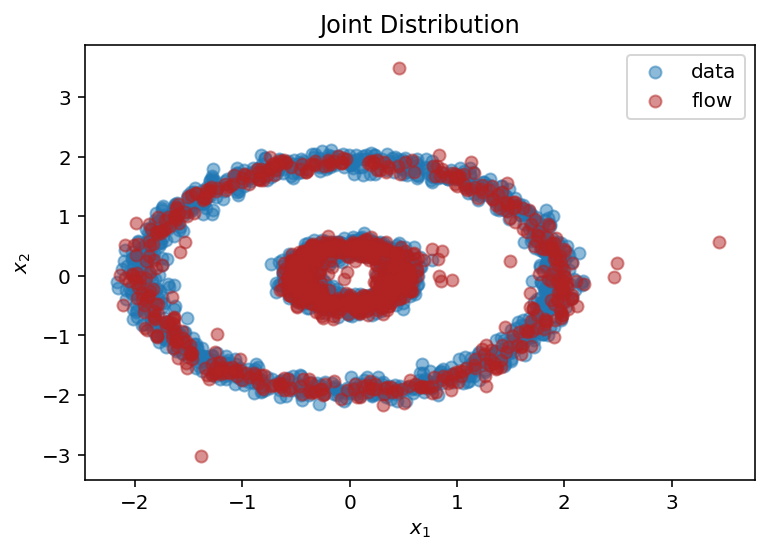

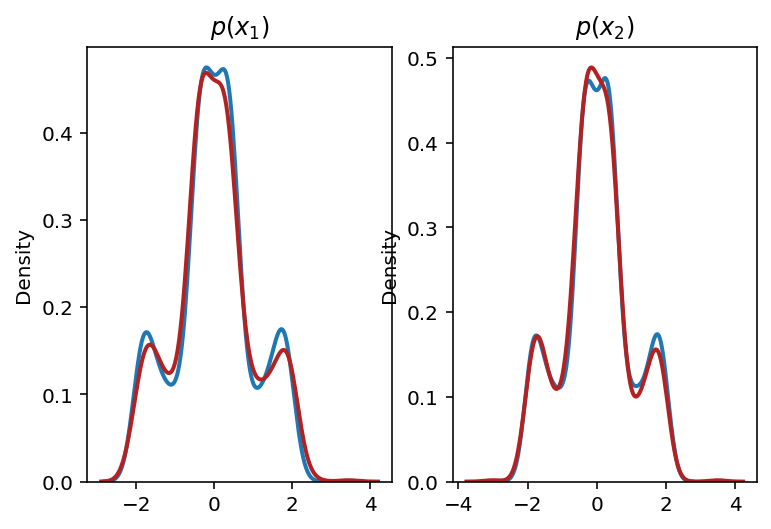

In [65]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show();

### Conditional Distributions

$$ p(x_1, x_2) = p(x_2 \mid x_1)p(x_1) $$



In [66]:
# first create the univariate distribution for x_1
dist_base = dist.Normal(torch.zeros(1), torch.ones(1))
x1_transform = T.spline(1)
dist_x1 = dist.TransformedDistribution(dist_base, [x1_transform])

In [67]:
# 
x2_transform = T.conditional_spline(1, context_dim=1)
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [x2_transform])

In [68]:
# to draw a sample from x_2 | x1 = 1, we do:
x1 = torch.ones(1)
print(dist_x2_given_x1.condition(x1).sample())

tensor([-0.1324])


In [69]:
%%time

steps = 5000
modules = torch.nn.ModuleList([x1_transform, x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)

x1 = dataset[:,0][:,None]
x2 = dataset[:,1][:,None]

for step in range(steps):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(x1)
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(x1.detach()).log_prob(x2.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 4.937025547027588
step: 500, loss: 1.7413890361785889
step: 1000, loss: 1.6469318866729736
step: 1500, loss: 1.6162891387939453
step: 2000, loss: 1.602219820022583
step: 2500, loss: 1.6050885915756226
step: 3000, loss: 1.625555157661438
step: 3500, loss: 1.6178690195083618
step: 4000, loss: 1.5930540561676025
step: 4500, loss: 1.5947563648223877
CPU times: user 55.9 s, sys: 3.11 s, total: 59 s
Wall time: 58.3 s


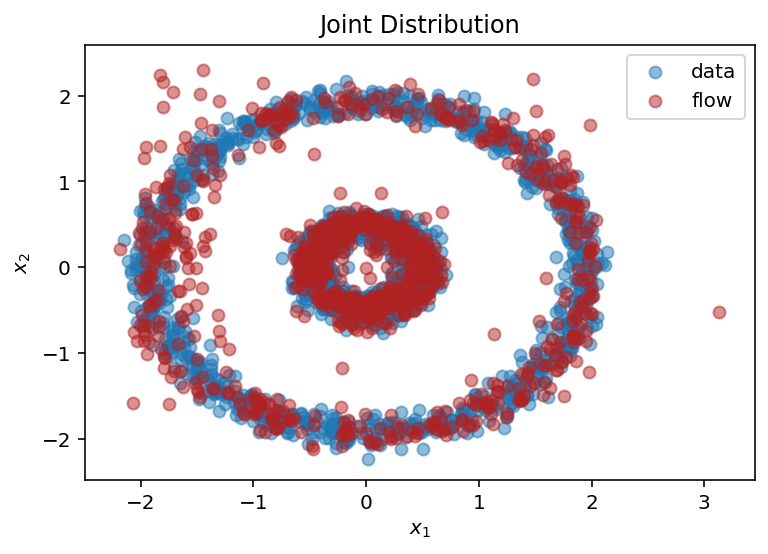

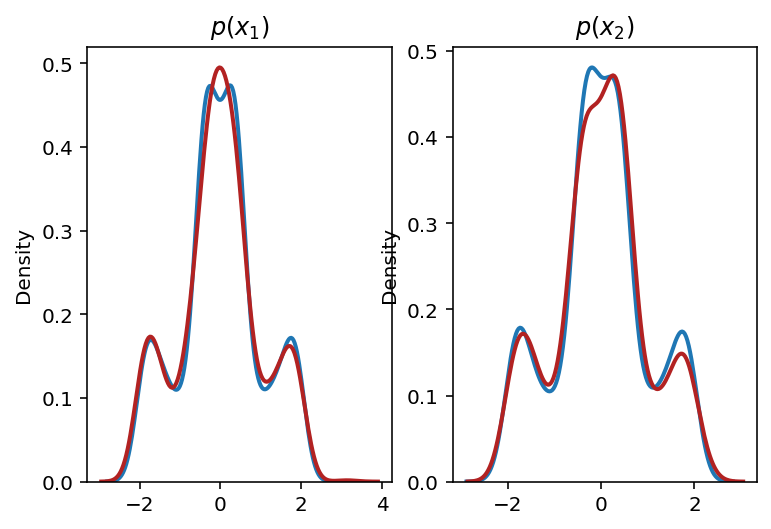

In [71]:
X = torch.cat((x1, x2), dim=-1)
x1_flow = dist_x1.sample(torch.Size([1000,]))
x2_flow = dist_x2_given_x1.condition(x1_flow).sample(torch.Size([1000,]))
X_flow = torch.cat((x1_flow, x2_flow), dim=-1)

plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show();